# ARIMAX Fit to Taxi Dataset

Here, we fit the ARIMAX model presented in `00_b_basic_ts_model.ipynb` for our final dataset.

### load packages

In [1]:
import sys, os
sys.path.append('..') # add parent directory to path

import numpy as np 
import pandas as pd
from utils import processing as pr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import statsmodels.api as sm

### Load Test Data from Previous Notebook (01_a_final_dataset.ipynb)

In [2]:
# load data
ts = pd.read_pickle('../../processed_taxi_data/adjusted_yellow_2022-01_2024-03_bypulocation.pkl')

# create a list of dataframes for each location
ts_dict = {} # dictionary of time series dataframes
loc_ids = ts['PULocationID'].unique()
for i in loc_ids:
    ts_z = ts[ts['PULocationID'] == i][['pickup_datetime', 'counts']].copy()
    ts_z.set_index('pickup_datetime', inplace = True) # time series model packages require datetime index
    ts_z['log_counts'] = np.log(1. + ts_z['counts']) # convert counts to log counts, 1 is added to avoid log(0)
    ts_dict[i] = ts_z

# ts_1['std_log_counts'] = (ts_1['log_counts'] - ts_1['log_counts'].mean()) / ts_1['log_counts'].std() # if you want to standardize

## Perform ARIMAX Fit
We do not perform a grid scan as is standard for ARIMA fits. We stick to order (p,d,q) = (1,1,1). Changing p or q above the chosen values does not change results significantly. The differencing d = 1 gives the best results. The key here is that the modelling the seasonality is more important in predicting taxi demand. 

In [3]:
def arimax_fit(ts_1):
    # Split data into training and validation sets
    begin = '2023-09-26 14:00:00-0400' # less data allows larger models to train successfully
    ts_data = ts_1['log_counts'][begin:]
    # ts_data = ts_1['log_counts']
    test_start = '2023-10-19 14:00:00-0400'
    ts_train = ts_data.loc[:test_start].iloc[:-1]
    ts_test = ts_data.loc[test_start:]
    N_train = len(ts_train) ; N_test = len(ts_test)

    def create_fourier_terms(series, period, K):
        t = np.arange(len(series))
        terms = pd.DataFrame({
            f'sin_{i}': np.sin(2 * np.pi * i * t / period) for i in range(1, K + 1)
        }).join(pd.DataFrame({
            f'cos_{i}': np.cos(2 * np.pi * i * t / period) for i in range(1, K + 1)
        }))
        return terms

    # Create Fourier terms for daily (24-hour) and weekly (168-hour) seasonality
    periods = [1,24, 24*7, 24*365]
    Ks = [6, 6, 6, 0]
    fourier_list_train = [create_fourier_terms(ts_data, period=period, K=Ks[i])[:N_train] for i, period in enumerate(periods)] # Kth-order Fourier terms for each period
    fourier_list_test = [create_fourier_terms(ts_data, period=period, K=Ks[i])[N_train:] for i, period in enumerate(periods)]

    # Combine exogenous variables
    exog_train = pd.concat(fourier_list_train, axis=1)
    exog_train.index = ts_train.index
    exog_test = pd.concat(fourier_list_test, axis=1)

    # Fit SARIMAX model with exogenous variables for multiple seasonalities (nelder-mead fastest convergence)
    sarimax_model = sm.tsa.statespace.SARIMAX(ts_train, order=(1, 1, 1), exog=exog_train).fit(
        maxiter = 100, method = 'nm'
        )

    # Forecasting
    forecast = sarimax_model.get_forecast(steps=N_test, exog=exog_test)
    forecast_index_1 = pd.date_range(start=ts_test.index[0], periods=396, freq='h') # ts_test is missing the 396th hour (verify that forecast_index == ts_test.index)
    forecast_index_2 = pd.date_range(start=ts_test.index[396], periods=N_test - 396, freq='h')
    forecast_index = forecast_index_1.append(forecast_index_2)
    forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)
    
    # Convert log counts to physical counts
    physical_forecast = np.exp(forecast_series) - 1.
    ts_test = np.exp(ts_test) - 1.

    # array versions of previous two quantities
    physical_forecast_arr = physical_forecast.to_numpy()
    ts_test_arr = ts_test.to_numpy()

    return sarimax_model, forecast_series, physical_forecast, ts_test, physical_forecast_arr, ts_test_arr

  0%|          | 0/63 [00:00<?, ?it/s]

/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


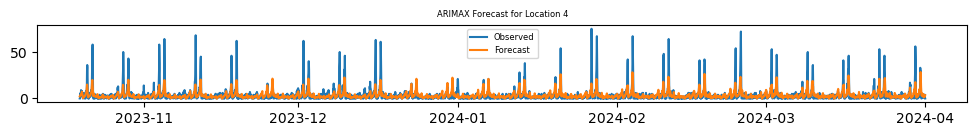

  2%|▏         | 1/63 [00:01<01:33,  1.50s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


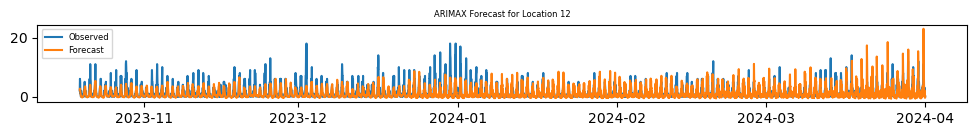

  3%|▎         | 2/63 [00:02<01:30,  1.49s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


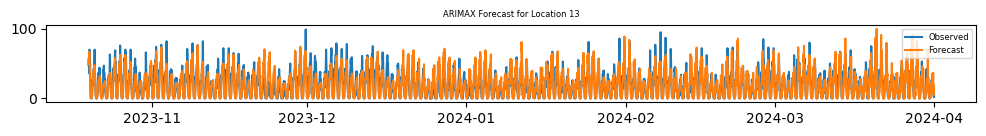

  5%|▍         | 3/63 [00:04<01:24,  1.41s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


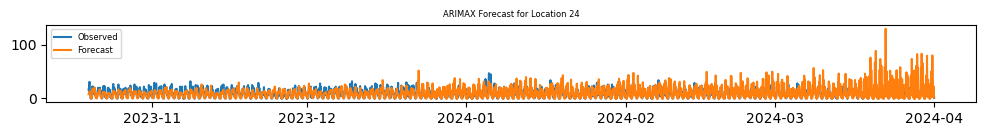

  6%|▋         | 4/63 [00:05<01:20,  1.37s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


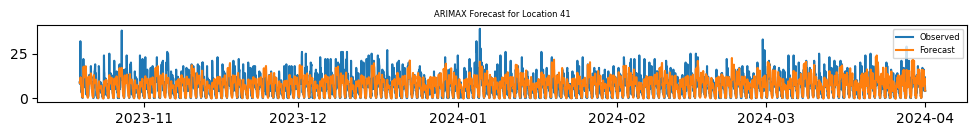

  8%|▊         | 5/63 [00:06<01:13,  1.26s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


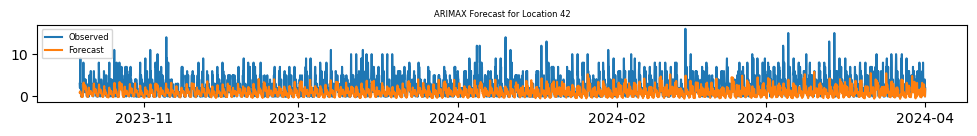

 10%|▉         | 6/63 [00:07<01:09,  1.22s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


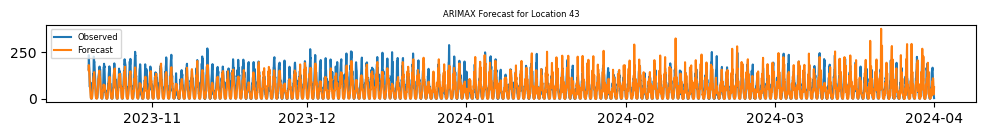

 11%|█         | 7/63 [00:09<01:08,  1.22s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


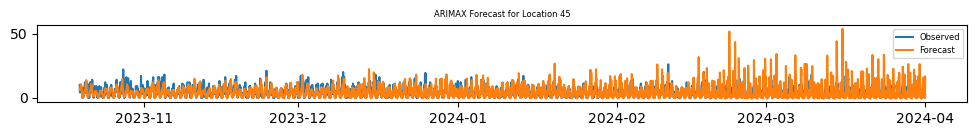

 13%|█▎        | 8/63 [00:10<01:07,  1.23s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


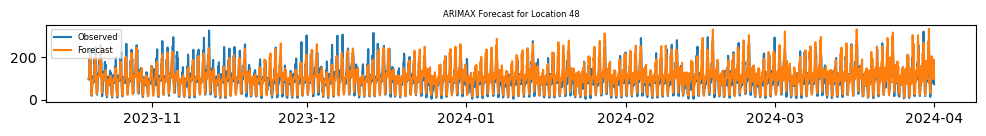

 14%|█▍        | 9/63 [00:11<01:14,  1.38s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


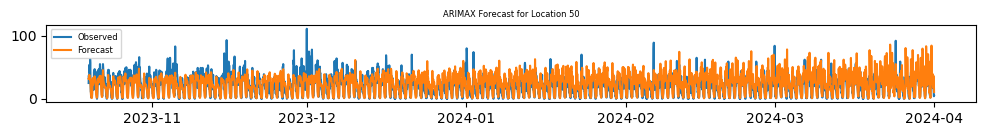

 16%|█▌        | 10/63 [00:12<01:06,  1.26s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


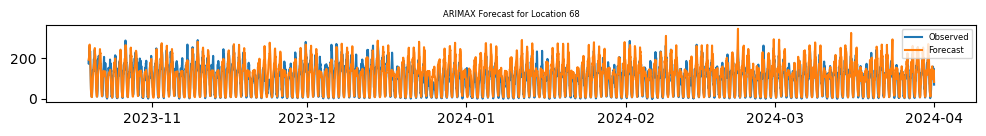

 17%|█▋        | 11/63 [00:14<01:08,  1.31s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


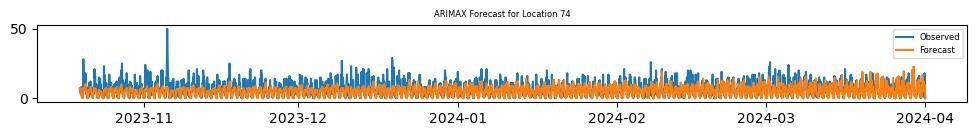

 19%|█▉        | 12/63 [00:15<01:00,  1.18s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


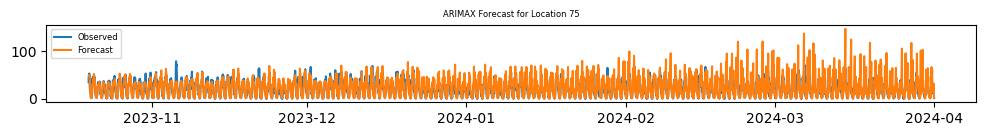

 21%|██        | 13/63 [00:16<01:01,  1.22s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


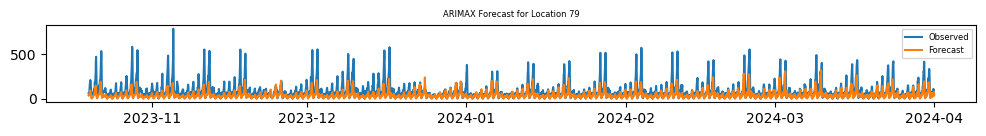

 22%|██▏       | 14/63 [00:17<01:01,  1.26s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


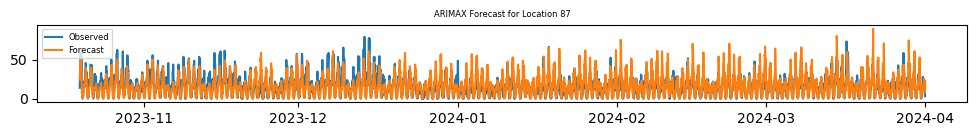

 24%|██▍       | 15/63 [00:19<01:03,  1.33s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


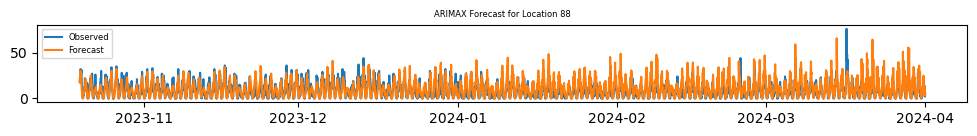

 25%|██▌       | 16/63 [00:20<01:03,  1.34s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


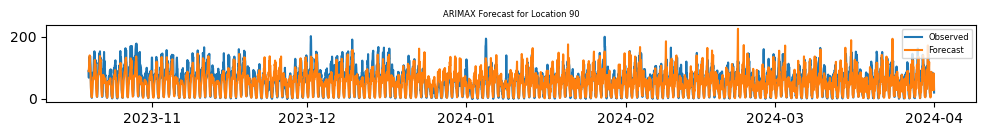

 27%|██▋       | 17/63 [00:21<00:57,  1.24s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


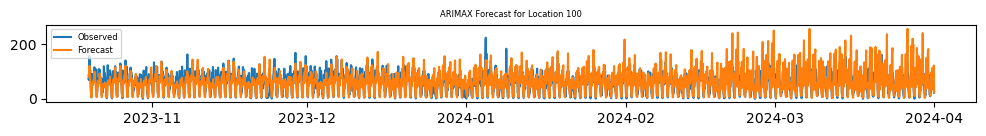

 29%|██▊       | 18/63 [00:22<00:54,  1.21s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


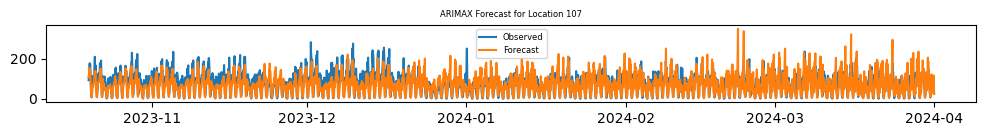

 30%|███       | 19/63 [00:23<00:49,  1.13s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


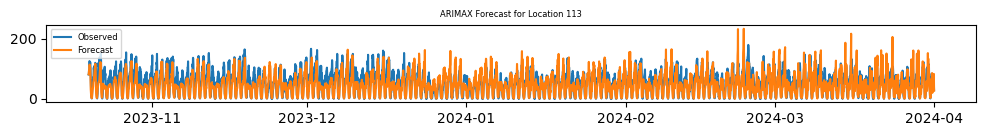

 32%|███▏      | 20/63 [00:26<01:03,  1.49s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


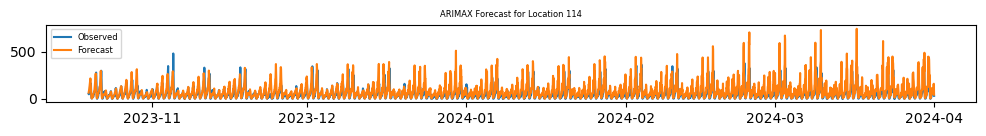

 33%|███▎      | 21/63 [00:27<00:54,  1.31s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


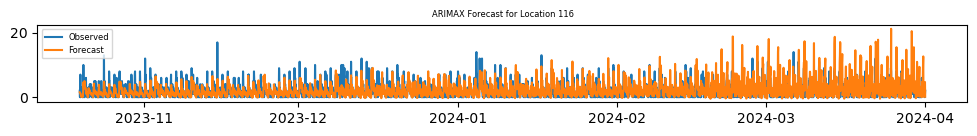

 35%|███▍      | 22/63 [00:28<00:51,  1.26s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


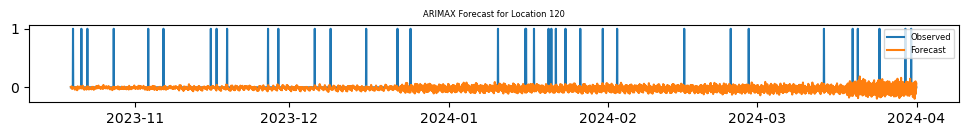

 37%|███▋      | 23/63 [00:29<00:46,  1.17s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


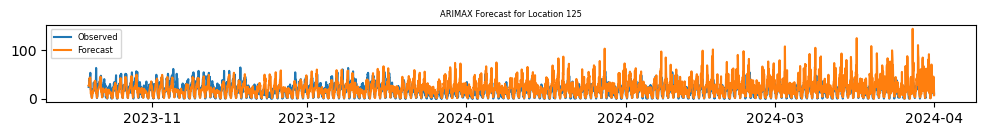

 38%|███▊      | 24/63 [00:31<00:54,  1.40s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


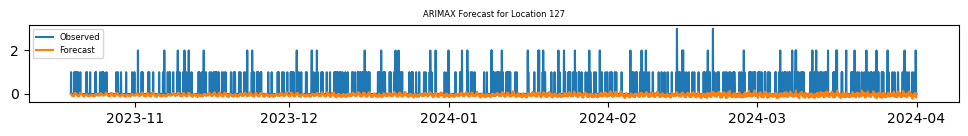

 40%|███▉      | 25/63 [00:32<00:48,  1.27s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


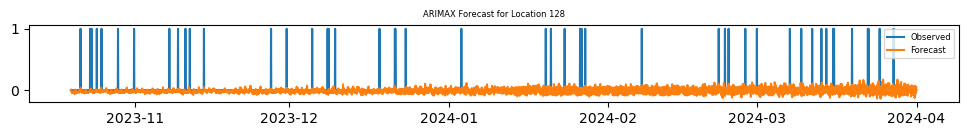

 41%|████▏     | 26/63 [00:33<00:44,  1.20s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


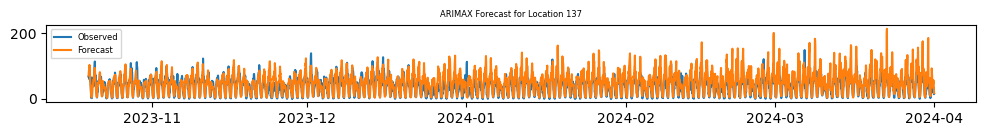

 43%|████▎     | 27/63 [00:34<00:39,  1.09s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


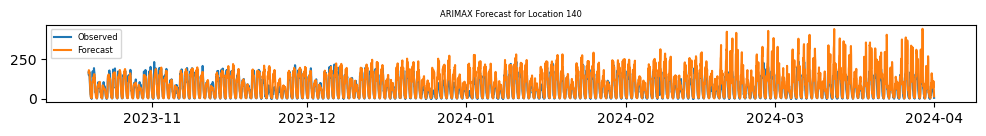

 44%|████▍     | 28/63 [00:35<00:42,  1.21s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


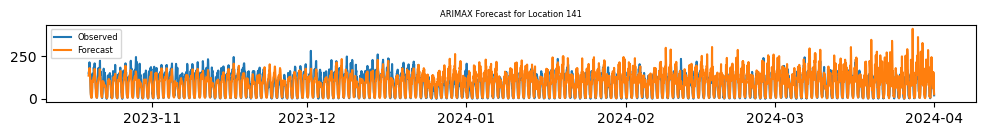

 46%|████▌     | 29/63 [00:37<00:44,  1.32s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


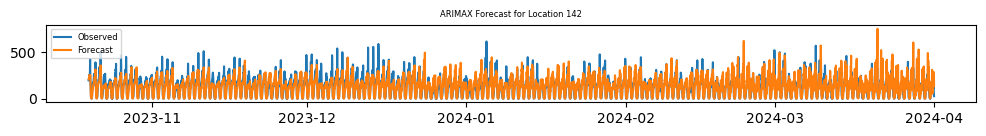

 48%|████▊     | 30/63 [00:38<00:44,  1.34s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


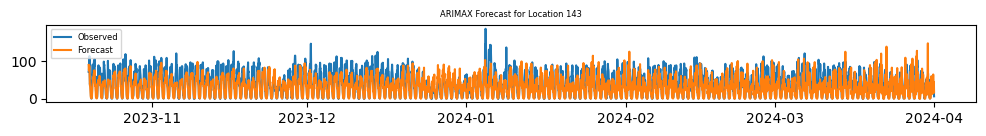

 49%|████▉     | 31/63 [00:39<00:40,  1.25s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


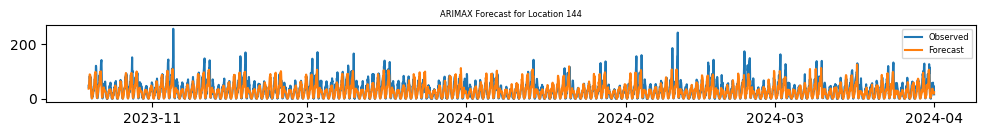

 51%|█████     | 32/63 [00:40<00:37,  1.21s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


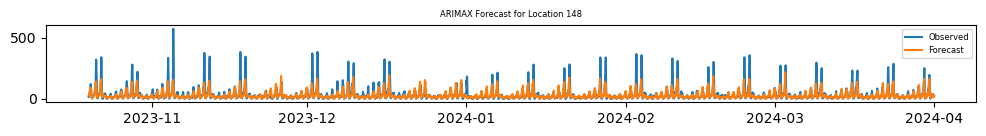

 52%|█████▏    | 33/63 [00:41<00:37,  1.25s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


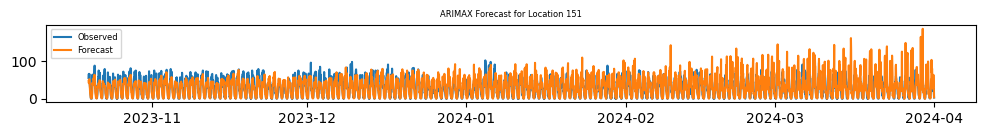

 54%|█████▍    | 34/63 [00:43<00:42,  1.46s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


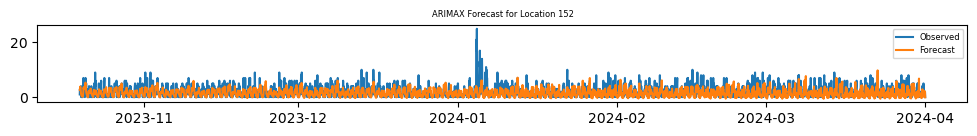

 56%|█████▌    | 35/63 [00:45<00:41,  1.50s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

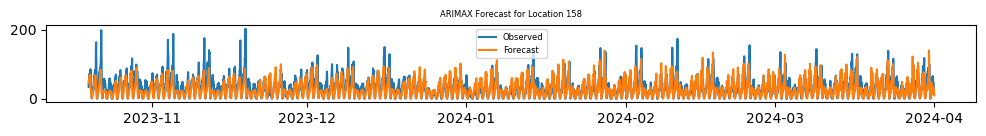

 57%|█████▋    | 36/63 [00:46<00:36,  1.37s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


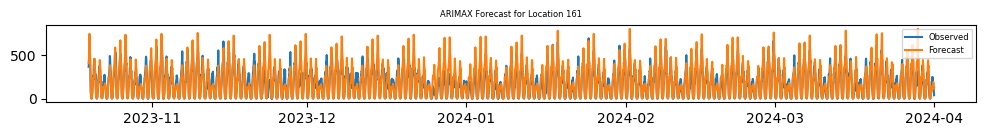

 59%|█████▊    | 37/63 [00:47<00:35,  1.37s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


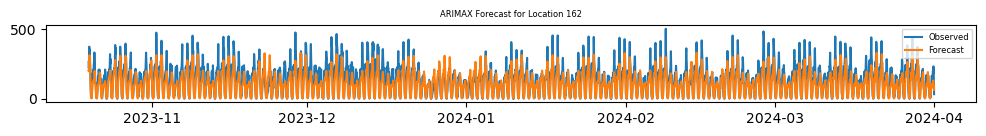

 60%|██████    | 38/63 [00:49<00:34,  1.38s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


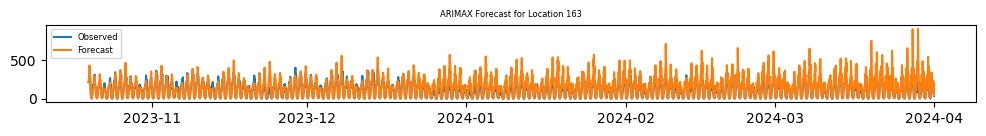

 62%|██████▏   | 39/63 [00:50<00:34,  1.42s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


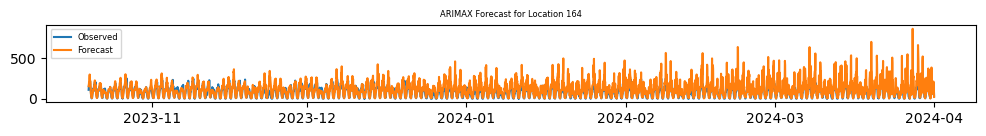

 63%|██████▎   | 40/63 [00:52<00:35,  1.54s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


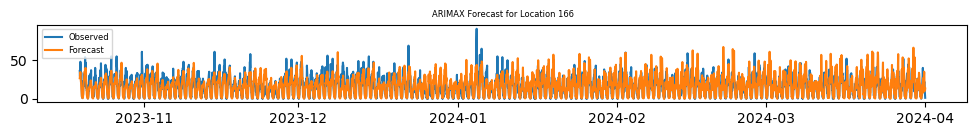

 65%|██████▌   | 41/63 [00:54<00:33,  1.52s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


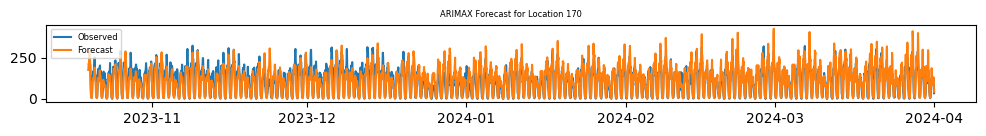

 67%|██████▋   | 42/63 [00:55<00:27,  1.32s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


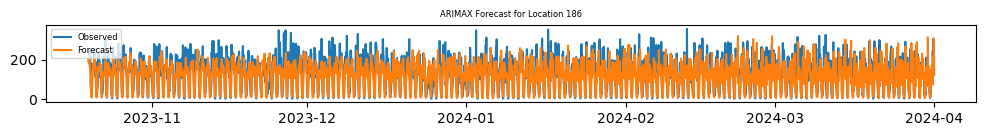

 68%|██████▊   | 43/63 [00:56<00:25,  1.25s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


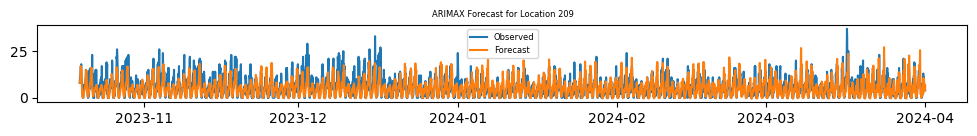

 70%|██████▉   | 44/63 [00:57<00:21,  1.15s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


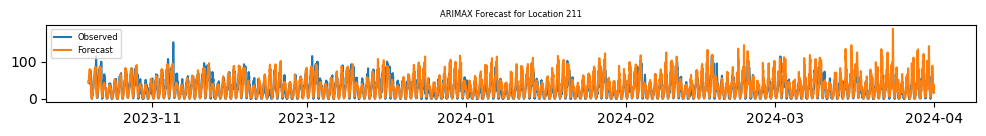

 71%|███████▏  | 45/63 [00:58<00:24,  1.35s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


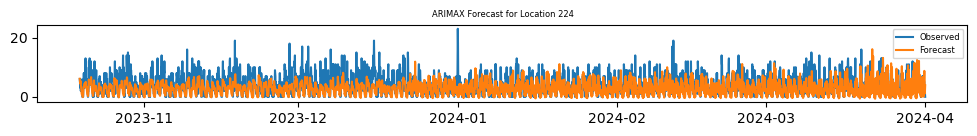

 73%|███████▎  | 46/63 [00:59<00:21,  1.27s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


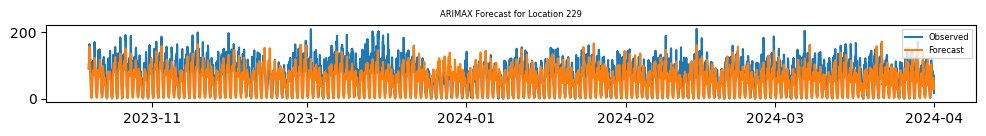

 75%|███████▍  | 47/63 [01:01<00:19,  1.24s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


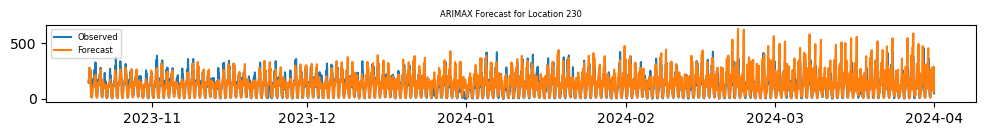

 76%|███████▌  | 48/63 [01:02<00:17,  1.17s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

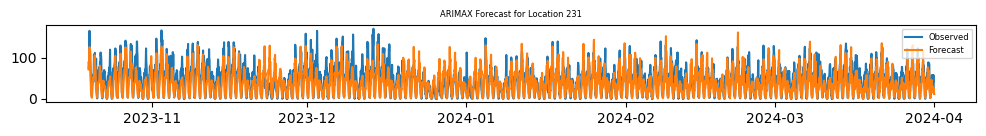

 78%|███████▊  | 49/63 [01:03<00:15,  1.11s/it]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


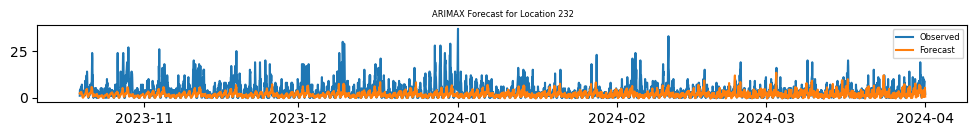

 79%|███████▉  | 50/63 [01:03<00:12,  1.06it/s]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


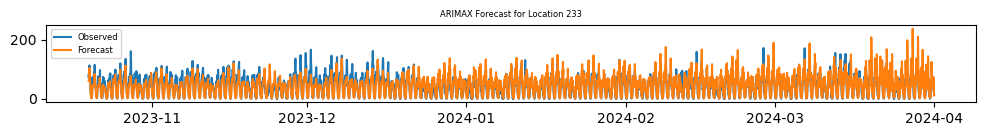

 81%|████████  | 51/63 [01:04<00:10,  1.20it/s]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


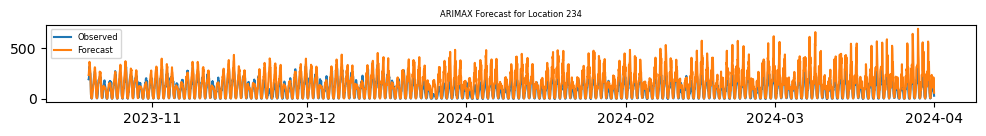

 83%|████████▎ | 52/63 [01:04<00:08,  1.27it/s]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


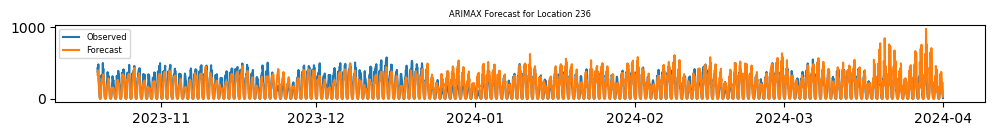

 84%|████████▍ | 53/63 [01:05<00:07,  1.37it/s]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


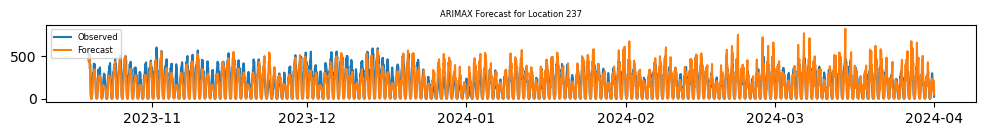

 86%|████████▌ | 54/63 [01:06<00:06,  1.44it/s]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


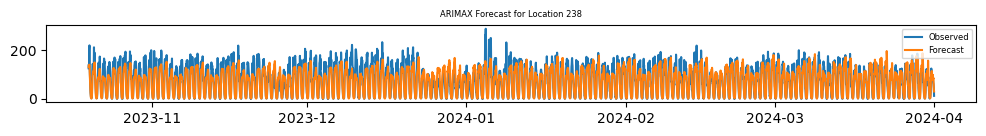

 87%|████████▋ | 55/63 [01:06<00:05,  1.39it/s]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


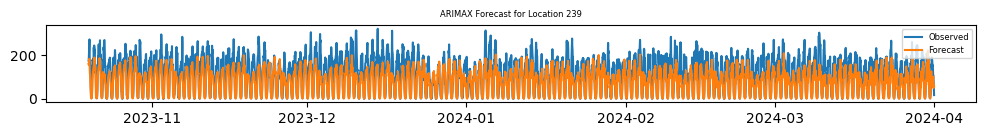

 89%|████████▉ | 56/63 [01:07<00:04,  1.41it/s]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


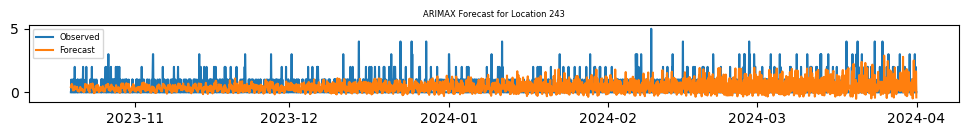

 90%|█████████ | 57/63 [01:08<00:04,  1.48it/s]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


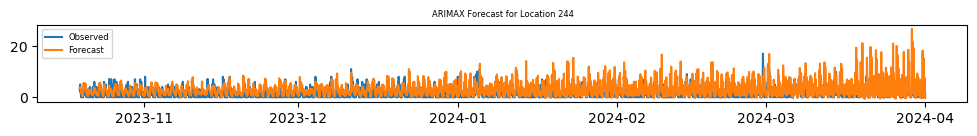

 92%|█████████▏| 58/63 [01:09<00:04,  1.18it/s]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


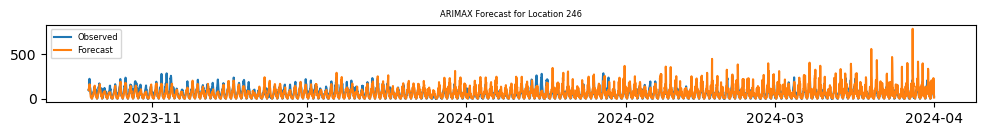

 94%|█████████▎| 59/63 [01:10<00:03,  1.29it/s]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


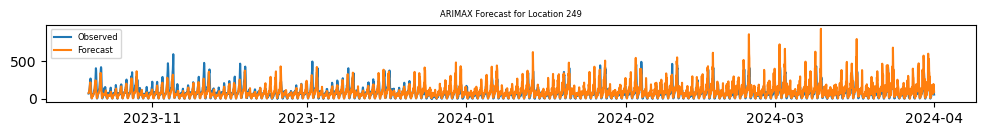

 95%|█████████▌| 60/63 [01:10<00:02,  1.30it/s]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


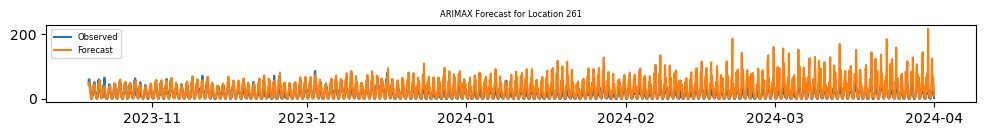

 97%|█████████▋| 61/63 [01:11<00:01,  1.36it/s]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


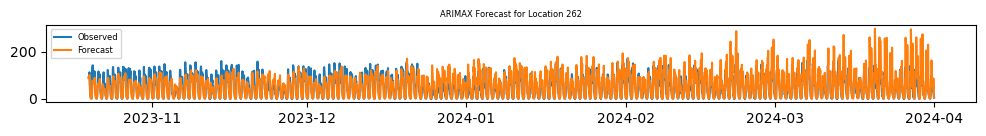

 98%|█████████▊| 62/63 [01:12<00:00,  1.39it/s]/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


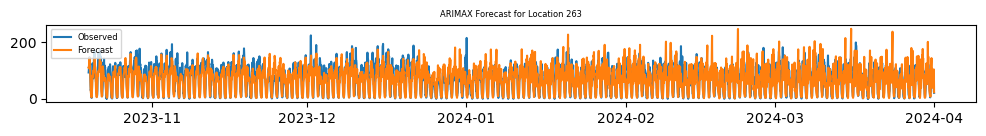

100%|██████████| 63/63 [01:12<00:00,  1.16s/it]


In [4]:
# perform fits across all taxi zones

sarimax_model_dict = {}
forecast_series_dict = {}
physical_forecast_dict = {}
ts_test_dict = {}

physical_forecast_arr_list = []
ts_test_arr_list = []

for i in tqdm(loc_ids):
    ts_z = ts_dict[i]
    sarimax_model, forecast_series, physical_forecast, ts_test, physical_forecast_arr, ts_test_arr = arimax_fit(ts_z)
    sarimax_model_dict[i] = sarimax_model
    forecast_series_dict[i] = forecast_series
    physical_forecast_dict[i] = physical_forecast
    ts_test_dict[i] = ts_test

    physical_forecast_arr_list.append(physical_forecast_arr)
    ts_test_arr_list.append(ts_test_arr)

    plt.figure(figsize=(12, 1))
    plt.plot(ts_test, label='Observed')
    plt.plot(physical_forecast, label='Forecast')
    plt.title(f'ARIMAX Forecast for Location {i}', fontsize=6)
    plt.legend(fontsize=6)
    plt.show()

In [5]:
# calculate MSE and sMAPE for comparison with deep learning models

def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def sMAPE(y_true, y_pred):
    return np.mean(2. * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

physical_forecast_arr_list = np.array(physical_forecast_arr_list)
ts_test_arr_list = np.array(ts_test_arr_list)

print('MSE:', MSE(ts_test_arr_list, physical_forecast_arr_list))
print('sMAPE:', sMAPE(ts_test_arr_list, physical_forecast_arr_list))

MSE: 1601.362848495505
sMAPE: 0.6956835368090483


In [27]:
# save predictions as CSV
df = pd.DataFrame.from_dict(physical_forecast_dict)
df['pickup_datetime'] = df.index
df = df.melt(id_vars='pickup_datetime', var_name='PULocationID', value_name='counts')
df.set_index('pickup_datetime', inplace=True)

df.to_csv('data/arimax_predictions.csv')